## Gráficas MTOW vs AP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

Obtenemos FM del rotor principal, aquí utilizamos densidad estándar

In [2]:
HELI = {'k': 1.15,
        'Cdo': 0.01,
        'Matip': 0.62,
        'm': 1451,
        'D': 5.08*2,
        'solidez': 0.0414,
        'P_d_ssl': 300}

### Obtener MTOW para diferentes temperaturas y altitud presión

Con esta potencia podemos obtener los distintos MTOW 

In [60]:
class Hover():
    """Clase que permite calcular la potencia requerida por un helicóptero en Hover
       Calcula la máxima velocidad de ascenso posible 
       Calcula MTOW a distintas altitud presión
       Inputs:
           Heli_data (diccionario): Diccionario que contiene los datos del helicoptero
           hdens: float. Valor de altitud densidad estándar
    """
    
    def __init__(self, Heli_Data, hdens):
        self.Heli_data =    Heli_Data
        self.Pd        =    Heli_Data['Pd']        # hp
        self.k         =    Heli_Data['k']
        self.Cdo       =    Heli_Data['Cdo']
        self.Ma_tip    =    Heli_Data['Ma_tip']    # m/s
        self.m         =    Heli_Data['m']         # kg
        self.D         =    Heli_Data['D']         # m
        self.solidez   =    Heli_Data['solidez']
        self.FM        =    Heli_Data['FM']
        
        self.A         = (1/4)*np.pi*self.D**2
        self.Vtip      = self.Ma_tip*340           # [m/s]
        self.omega     = self.Vtip/(self.D/2)      # [rad/s]
        self.GTOW      = 9.81*self.m               # [N]
        Dens_ssl       = 1.225                     # [kg/m3]
        
        self.hdens      = hdens
        self.dens_hd    = 1.225*(1-self.hdens*(0.00357/518.4))**(1/0.235)
        self.dens_ratio = self.dens_hd/1.225
        
        # Obtenemos FM a nivel del mar con las potencias para hover a nivel del mar
        if self.FM == 0:
            self.Pi_ssl = (self.GTOW**1.5)/(2*1.225*self.A)**0.5
            self.Po_ssl = 1.225*self.A*((self.omega*(self.D/2))**3) * (self.solidez*self.Cdo/8)
            self.FM = self.Pi_ssl/(self.k*self.Pi_ssl + self.Po_ssl)
        else:
            pass
        
        self.alt_presion  = [x for x in range(0, 14100, 500)]  #hp de 0 a 14000 pies
        self.list_dens_hp = [h for h in self.alt_presion]   #lista densidad a distinta altitud presión a una temperatura dada
        self.list_mtow    = [h for h in self.alt_presion]   #lista MTOW a distinta altitud presión a la temperatura dada
        self.list_GTOW    = []
        self.list_Pexceso = []
        
        #Obtener Potencia nominal, aquí utilizamos con GTOW ssl y densidad de UPIIG en ese momento, dens = 1.046 kg/m^3
        #Este valor es usado para calcular los MTOW a diferentes hp y T
        self.P = (self.GTOW**1.5)/(self.FM*(2*1.046*self.A)**0.5)     #[Watts]
        
        self.list_P = []
        
        self.P_FM = 0
        self.P_k  = 0
        
    def densidad_hp(self, temperatura):
        '''
        Método que obtiene una lista de densidades variando la altitud presión, a una temperatura establecida
        Inputs:
                temperatura: En °C
        '''
        self.temperatura = temperatura
        
        i = 0
        for h_presion in self.alt_presion:
            dens = 1.225*(288.16/(temperatura + 273.16)) * (1-(0.001981 * h_presion/288.16))**5.256
            self.list_dens_hp[i] = round(dens,3)
            i += 1

    def mtow(self, temperatura):
        '''
        Método que obtiene una lista de MTOW a la temperatura dada, variando altitud presión y densidad
        Inputs:
                temperatura: float. Temperatura en °C
        '''
        self.densidad_hp(temperatura)
        self.temperatura = temperatura
        
        i = 0
        for dens_hp in self.list_dens_hp:
            w = (self.P*self.FM*(2*dens_hp*self.A)**0.5)**(0.66)
            self.list_mtow[i] = round(w,3)
            i += 1
            
    def potencia_hover(self):
        """Método que calcula la potencia en Hover (hp) a distintos GTOW (lb) para la hdens inicializada
           Revisar datos de list_GTOW (lb) & hdens (ft)
           Puede cambiarse a kg y Newtons modificando lo que multiplica a W & quitando el / 745.7
           Este método usa la fórmula que involucra el coeficiente de pérdidas inducidas
        """
        self.list_GTOW = [x for x in range(16000, 21500, 500)] # [lb]
        self.list_P = [0 for x in self.list_GTOW]
        
        i = 0
        for W in self.list_GTOW:
            P = (self.k*(W*0.453592*9.81)**1.5) / (2*self.dens_hd*self.A)**0.5 + self.dens_hd*self.A*(self.solidez*self.Cdo/8)*((self.Vtip)**3)
            self.list_P[i] = P/745.7
            i += 1
            
    def calc_potencia_exceso(self):
        """Método que calcula la potencia excedente (hp) a distintos GTOW
        """
        self.potencia_hover()
        self.list_Pexceso = [0 for x in self.list_P]
        
        i = 0
        for P_h in self.list_P:
            Pexc = self.Pd*(self.dens_hd/1.225) - P_h
            self.list_Pexceso[i] = Pexc
            i += 1
                    
            
    def calc_potencia_FM(self):
        """Método que calcula la potencia requerida para el GTOW inicializado y a una hdens inicializada
           usando el método que incluye FM
        """
        self.__init__(self.Heli_data, self.hdens)
        self.P_FM = (1/745.7)*(1/self.FM)*((self.GTOW**1.5)/(2*self.dens_hd*self.A)**0.5)
        
    def calc_potencia_k(self):
        """Método que calcula la potencia requerida para el GTOW inicializado y a una hdens inicializada
           usando el método que incluye el fáctor de pérdidas inducidas
        """
        self.__init__(self.Heli_data, self.hdens)
        self.P_k = (self.k*self.GTOW**1.5)/(2*self.dens_hd*self.A)**0.5 + self.dens_hd*self.A*(self.Vtip**3)*(self.solidez*self.Cdo/8)
        self.P_k = self.P_k/745.7
        
    def calc_techo_FM(self, alt_inicial):
        """Método que calcula el techo de servicio utilizando P_FM y variando la hdens inicializada
        """
        Error = 1000
        
        alt_dens   = alt_inicial
        self.hdens = alt_dens
        
        while Error > 0.01:
            self.hdens = alt_dens
            self.calc_potencia_FM()
            Error = abs(self.dens_ratio * self.Pd - self.P_FM)
            alt_dens += 0.1
        return f'Techo de servicio: {alt_dens} ft'
    
    def calc_techo_k(self, alt_inicial):
        """Método que calcula el techo de servicio utilizando P_k y variando la hdens inicializada
        """
        Error = 1000
        
        alt_dens   = alt_inicial
        self.hdens = alt_dens
        
        while Error > 0.01:
            self.hdens = alt_dens
            self.calc_potencia_k()
            Error = abs(self.dens_ratio * self.Pd - self.P_k)
            alt_dens += 0.1
        return f'Techo de servicio: {alt_dens} ft'
            
    def graf_mtow(self, temperatura):
        '''
        Método que calcula mtow y grafica MTOW vs Altitud Presión, obtiene los mtow
        de self.mtow a una temperatura dada
        Inputs:
                temperatura: float. Temperatura en °C
        '''
        self.mtow(temperatura)
        
        plt.plot(self.list_mtow, self.alt_presion, label = '{}°C'.format(self.temperatura))
        plt.xlabel('MTOW [kg]')
        plt.ylabel('ALTITUD PRESIÓN [ft]')
        plt.title('MTOW vs AP')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        
    def graf_PvsGTOW(self):
        '''Método que calcula la potencia en hover y grafica Potencia [hp] vs GTOW [lb]
        '''
        self.potencia_hover()
        
        plt.plot(self.list_GTOW, self.list_P, label = "{}'".format(self.hdens))
        plt.xlabel('GTOW [lb]')
        plt.ylabel('Potencia Requerida [hp]')
        plt.title('P vs GTOW')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        
    def graf_P_exceso(self):
        '''Método que calcula Potencia de exceso y grafica Potencia Exceso [hp] vs GTOW [lb]
        '''
        self.calc_potencia_exceso()
        
        plt.plot(self.list_GTOW, self.list_Pexceso, label = "{}'".format(self.hdens))
        plt.xlabel('GTOW [lb]')
        plt.ylabel('Potencia en Exceso [hp]')
        plt.title('P Excedente vs GTOW')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        
    def __str__(self):
        return 'Temperatura: {}'.format(self.temperatura)
        

### AP vs MTOW

Ejemplo gráfica MTOW a distintas altitud presión y temperatura

In [6]:
Heli1_data = {'k': 1.15, 'Cdo': 0.01, 'Ma_tip': 0.62, 'm': 1451, 'D': 10.16, 'solidez': 0.0414, 'Pd': 2800, 'FM': 0}

In [14]:
tdata_m20 = Hover(Heli1_data, 0)
tdata_m10 = Hover(Heli1_data, 0)
tdata_0 =   Hover(Heli1_data, 0)
tdata_10 =  Hover(Heli1_data, 0)
tdata_20 =  Hover(Heli1_data, 0)

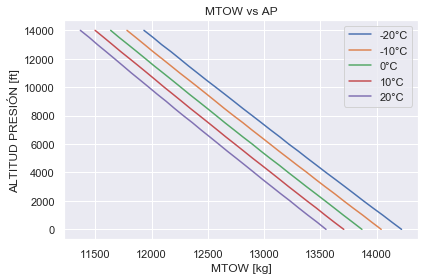

In [15]:
tdata_m20.graf_mtow(-20)
tdata_m10.graf_mtow(-10)
tdata_0.graf_mtow(0)
tdata_10.graf_mtow(10)
tdata_20.graf_mtow(20)

### Potencia vs GTOW

Ejemplo gráfica Potencia Requerida a distintos GTOW

In [20]:
Ex_Heli = {'k': 1.15, 'Cdo': 0.008, 'Ma_tip': 0.65, 'm': 1451, 'D': 8.23*2, 'solidez': 0.082, 'Pd': 2800, 'FM': 0}

In [24]:
Heli_Ex_0 = Hover(Ex_Heli, 0)
Heli_Ex_3000 = Hover(Ex_Heli, 3000)
Heli_Ex_6000 = Hover(Ex_Heli, 6000)
Heli_Ex_9000 = Hover(Ex_Heli, 9000)

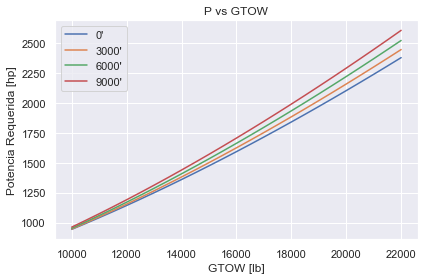

In [25]:
Heli_Ex_0.graf_PvsGTOW()
Heli_Ex_3000.graf_PvsGTOW()
Heli_Ex_6000.graf_PvsGTOW()
Heli_Ex_9000.graf_PvsGTOW()

## Comparación entre Potencia Requerida a hd = 0 ft para ambos métodos (FM & k)

In [51]:
Heli_Ex_0 = Hover(Heli1_data, 0)

In [53]:
Heli_Ex_0.calc_potencia_k()
Heli_Ex_0.P_k

250.39151991055033

In [54]:
Heli_Ex_0.calc_potencia_FM()
Heli_Ex_0.P_FM

250.3915199105503

## Potencia excedente

In [57]:
Ex_Heli = {'k': 1.15, 'Cdo': 0.008, 'Ma_tip': 0.65, 'm': 1451, 'D': 8.23*2, 'solidez': 0.082, 'Pd': 2800, 'FM': 0}

In [61]:
Pex_hd0 = Hover(Ex_Heli, 0)
Pex_hd3000 = Hover(Ex_Heli, 3000)
Pex_hd6000 = Hover(Ex_Heli, 6000)
Pex_hd9000 = Hover(Ex_Heli, 9000)

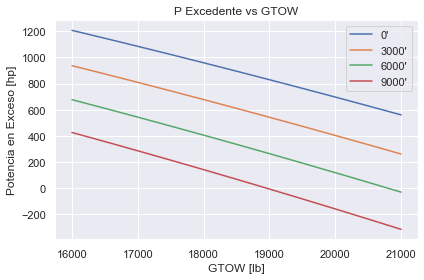

In [63]:
Pex_hd0.graf_P_exceso()
Pex_hd3000.graf_P_exceso()
Pex_hd6000.graf_P_exceso()
Pex_hd9000.graf_P_exceso()

## Techo fórmula FM

In [65]:
Heli_techo = {'k': 1.15, 'Cdo': 0.01, 'Ma_tip': 0.62, 'm': 1451, 'D': 10.16, 'solidez': 0.0414, 'Pd': 300, 'FM': 0}

Hacemos unas cuantas iteraciones para obtener una altitud a partir de la cual comenzar el método calc_FM

In [72]:
techo = Hover(Heli_techo, 3000)

techo.calc_potencia_FM()
techo.P_FM

261.76392526602376

In [73]:
techo.dens_hd/1.225*techo.Pd

274.49908337138265

In [62]:
techo.calc_techo_FM(3000)

'Techo de servicio: 4053.7999999990416 ft'

## Techo fórmula k

Hacemos unas cuantas iteraciones para obtener una altitud a partir de la cual comenzar el método calc_FM

In [77]:
techo = Hover(Heli_techo, 3000)

techo.calc_potencia_k()
techo.P_k

253.34375706895847

In [78]:
techo.dens_hd/1.225*techo.Pd

274.49908337138265

In [79]:
techo.calc_techo_k(3000)

'Techo de servicio: 5283.400000003323 ft'